# **COMO CONSTRUIR UMA CNN COM PYTORCH**

Iremos aplicar ao dataset MNIST. Mas antes disso, iremos ver cada parte de módulos fundamentais do Pytorch que facilitam nossa vida.

- Iremos importar as funções
- Definir nosso transformador, que é a classe que realiza transformações nas imagens
- Carregar o dataset. 
- Inspecionar e visualizar o dataset
- criar um DataLoader para carregar batches de imagens
- Contruir o modelo
- Treinar o modelo 
- Analisar a acurácia
- Salvando o modelo
- Visualizar os logs de treino.


In [1]:
import torch

#nos usamos o torchvision para carregar o dataset e usar transformações nas imagens
import torchvision
import torchvision.transforms as transforms

#iremos também, importar os otimizadores para a rede e a rede em si.
import torch.nn as nn
import torch.optim as optim



In [2]:
#Verificar se temos GPU para rodar nossos experimentos.
print("GPU disponível: {}".format(torch.cuda.is_available()))

#Normalmente se define cuda ou cpu, para não ter problemas de compatibilidade com o pytorch
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

GPU disponível: True


### Transformadores

Os transformadores são necessários para converter os dados da imagem no formato necessário para a entrada em nosso modelo.

- Ele é composto usando a função ```transforms.Compose```
- Encadeamos os comandos ou instruções do nosso pipeline como argumentos
- Usamos ```transforms.ToTensor()``` para converter os dados da imagem em um Tensor PyTorch
- Usamos ```transforms.Normalize()``` para normalizar nossos valores de pixel
- Ao passar a entrada como ```(0.5, ), (0.5,)```, normalizamos nossos dados de imagem entre -1 e +1 
- Observação: para imagens RGB, usamos ```transformed.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))``` 


**NOTA**:
Nossos valores brutos de pixel em nosso conjunto de dados MNIST variam de 0 a 255. Cada imagem tem 28 pixels de altura e 28 pixels de largura, com uma profundidade de 1, pois é em escala de cinza.

**Por que normalizar?**

1. Para garantir que todos os recursos ou, no nosso caso, as intensidades dos pixels, sejam ponderados igualmente ao treinar a CNN
2. Torna o treinamento mais rápido, pois evita oscilações durante o treinamento
3. Remove o viés ou a distorção em nossos dados de imagem


**Por que 0,5?**

A normalização é feita da seguinte forma:

`image = (image - mean) / std`

Usar os parâmetros 0,5,0,5 define a média e o STD como 0,5. Usando a fórmula acima, obtemos o seguinte

- Valor mínimo = `(0-0,5)/0,5 = 1`
- Valor máximo = `(1-0,5)/0,5 = -1`

Para imagens coloridas, usamos uma tupla de (0.5,0.5,0.5) para definir a média dos canais RGB como 0.5 e outra tupla de (0.5, 0.5, 0.5) para definir o STD como 0.5

Já a transformação de ToTensor(), cria tensores.

Os tensores no PyTorch são estruturas de dados fundamentais usadas para representar e manipular dados multidimensionais, semelhantes a arrays do NumPy, mas com funcionalidades avançadas para computação numérica e aprendizado de máquina. Eles são a unidade básica de operação no PyTorch e permitem cálculos eficientes, inclusive em GPUs. Aqui estão os principais aspectos:

- Generalização de escalares, vetores e matrizes, Tensores podem ter N dimensões

- Atributos chave: shape, dtype, device.

- Computação Acelerada (GPU)

- Operações Numéricas
    - Aritmética: Adição (+), multiplicação (*), produto matricial (@ ou torch.matmul).

    - Redimensionamento: .view(), .reshape(), .transpose().

    - Funções matemáticas: torch.sin(), torch.exp(), torch.sum().

    - Indexação e slicing: Semelhante ao NumPy
- Integração com NumPy
- Tensores podem rastrear gradientes se requires_grad=True for definido, habilitando o cálculo automático de derivadas (útil para treinar redes neurais).

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
#Dessa forma, a gente normaliza os valores entre -1 e 1

### **Obtendo o conjunto de dados MNIST usando o torchvision**

**NOTA** 

- Muitos tutoriais on-line afirmam que as transformações são aplicadas no carregamento. Isso NÃO é verdade. Os transformadores são aplicados somente quando carregados pelo nosso Data Loader. 
- Nosso conjunto de dados permanece inalterado, apenas os lotes de imagens carregados pelo nosso Data Loader são copiados e transformados a cada iteração.
- Veja outros conjuntos de dados que podem ser acessados via torchvision aqui - https://pytorch.org/vision/stable/datasets.html


In [4]:
#Carregando o conjunto de treino e especificando qual transformador sera usado durante o carregamento. 

trainset = torchvision.datasets.MNIST('mnist', train = True, download= True, transform = transform)

#Carregando os dados de teste e especificando qual transformador sera usando durante o carregamento.

testset = torchvision.datasets.MNIST('mnist', train = False, download= True, transform = transform)

### Sobre os dados de treinamento e teste

Há dois subconjuntos de dados que estão sendo usados aqui:

- Dados de treinamento** Dados que são usados para otimizar os parâmetros do modelo (usados durante o treinamento)
- Dados de teste/validação** Dados que são usados para avaliar o desempenho do modelo 

Durante o treinamento, monitoramos o desempenho do modelo nos dados de teste.

**Boa prática de aprendizado de máquina**

Geralmente, mantemos outro **conjunto de testes** para testar o modelo final a fim de obter uma estimativa imparcial da precisão *fora da amostra*. 

No entanto, o MNIST não tem um conjunto de teste separado. Portanto, usamos o conjunto de teste para validação e teste. 


In [5]:
# Temos 60.000 amostras de imagem para nossos dados de treinamento e 10.000 para nossos dados de teste
# Cada uma tem 28 x 28 pixels e, como são em escala de cinza, não há uma terceira dimensão em nossa imagem

print(trainset.data.shape)
print(testset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


#### **Vamos dar uma olhada em uma amostra individual de dados**

Você verá que nossos dados ainda não foram normalizados entre -1 e 1.

In [6]:
print(trainset.data[0].shape)
print(trainset.data[0])

torch.Size([28, 28])
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,  

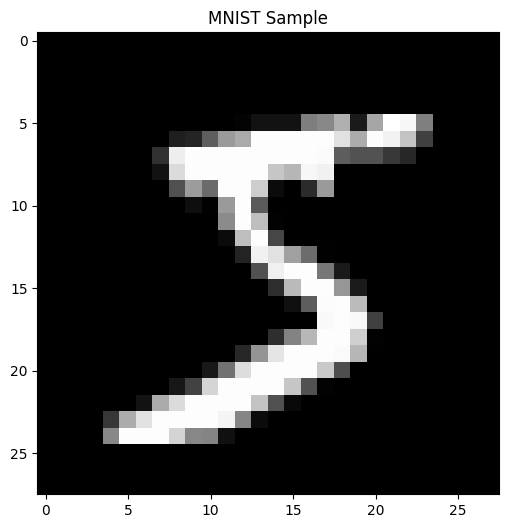

In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Define uma funcao para mostrar imagens
def imgshow(title="", image = None, size = 6):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

# Converter uma imagem para numpy
image = trainset.data[0].numpy()
imgshow("MNIST Sample", image)

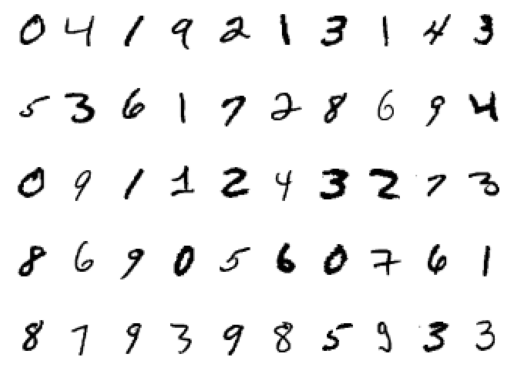

In [8]:
import matplotlib.pyplot as plt

figure = plt.figure()
num_of_images = 50 

for index in range(1, num_of_images + 1):
    plt.subplot(5, 10, index)
    plt.axis('off')
    plt.imshow(trainset.data[index], cmap='gray_r')

### CRIANDO UM DATALOADER

Um **Data Loader** é uma função que usaremos para obter nossos dados em tamanhos de lote especificados (usaremos 128) durante o treinamento. 

Lembre-se de que não podemos alimentar a rede com todos os dados de uma só vez, portanto, é por isso que dividimos os dados em lotes. 

Definimos **shuffle** igual a True para evitar a distorção da sequência de dados. Por exemplo, em alguns conjuntos de dados, cada classe geralmente está em ordem, portanto, para evitar o carregamento de lotes de apenas uma única classe, embaralhamos nossos dados.

O ``num_workers`` especifica quantos núcleos de CPU desejamos utilizar; defini-lo como 0 significa que será o processo principal que fará o carregamento de dados quando necessário. Deixe-o como 0, a menos que deseje fazer mais experimentos.



In [9]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)

In [11]:
#Para podermos manipular mais facilmente, iremos transformar nosso dataloader de treino em um iterator
dataiter = iter(trainloader)

#nos usamos a função next, para pegar o primeiro batch dos dados em nosso iterator
images, labels = dataiter._next_data()

print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [12]:
images[0].shape

torch.Size([1, 28, 28])

### O Pytorch também possui funções de visualização das imagens

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


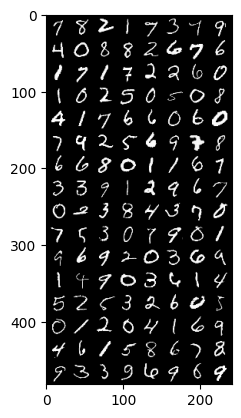

7 8 2 1 7 3 7 9 4 0 8 8 2 6 7 6 1 7 1 7 2 2 6 0 1 0 2 5 0 5 0 8 4 1 7 6 6 0 6 0 7 9 2 5 6 9 7 8 6 6 8 0 1 1 6 7 3 3 9 1 2 9 6 7 0 2 3 8 4 3 7 0 7 5 3 0 7 9 0 1 9 6 9 2 0 3 6 9 1 4 9 0 3 6 1 4 5 2 5 3 2 6 0 5 0 1 2 0 4 1 6 9 4 6 1 5 8 6 7 8 9 3 3 9 6 9 6 9


In [15]:
import matplotlib.pyplot as plt
import numpy

def imshow(image):
    img = image / 2 + 0.5
    npimg = image.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()


#pegar algumas imagens

dataiter = iter(trainloader)
images, labels = dataiter._next_data()

imshow(torchvision.utils.make_grid(images))
print(" ".join('%1s' % labels[j].numpy() for j in range(128)))

# CONTRUINDO O MODELO

Usaremos o método ```nn.Sequential`` para construir nosso modelo. Como alternativa, podemos usar o módulo funcional, mas ele é mais simples e mais semelhante aos estilos com os quais você trabalhará no Keras.

### Construindo uma camada de filtro de convolução**

```
nn.Conv2d(in_channels=1,
          out_channels=32,
          kernel_size=3,
          stride=1, 
          padding=1)
```

- **in_channels (int)** - Esse é o número de canais na imagem de entrada (para imagens em escala de cinza, use 1 e para imagens coloridas RGB, use 3)
- **out_channels (int)** - Esse é o número de canais produzidos pela convolução. Usamos 32 canais ou 32 filtros. **NOTA** 32 será o número de **in_channels** na próxima camada da rede.
- **kernel_size (int ou tuple)** - Este é o tamanho do kernel de convolução. Usamos 3 aqui, o que dá um tamanho de kernel de 3 x 3.
- stride (int ou tupla, opcional)** - Stride da convolução. (Padrão: 1)
- **padding (int ou tupla, opcional)** - Preenchimento zero adicionado a ambos os lados da entrada (Padrão: 0). Usamos um padding = 1.

### **Camada de Max Pool**

- Cada camada de pooling, ou seja, nn.MaxPool2d(2, 2), reduz pela metade a altura e a largura da imagem, portanto, ao usar 2 camadas de pooling, a altura e a largura são 1/4 dos tamanhos originais.

**O que é torch.nn.functional?**

Geralmente importado para o namespace F por convenção, esse módulo contém todas as funções da biblioteca torch.nn (enquanto outras partes da biblioteca contêm classes). Além de uma ampla gama de funções de perda e ativação, você também encontrará aqui algumas funções convenientes para a criação de redes neurais, como funções de pooling. (Há também funções para fazer convoluções, camadas lineares, etc., mas, como veremos, essas funções geralmente são mais bem tratadas em outras partes da biblioteca).

In [16]:
import torch.nn as nn
import torch.nn.functional as F

#Modelo é criado usando uma classe

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #Definindo objetos de camadas.
        #Primeira camada com 32 kernels de 3x3 de tamanho, com stride 1 e padding 0.
        self.conv1 = nn.Conv2d(1,32,3,1,0)
        #A segunda camada com 64 filtros de 3x3 de tamanho, com stride 1 e padding 0.
        self.conv2 = nn.Conv2d(32,64,3,1,0)
        #Camada de max pooling 2x2, kernel com stride 2
        self.pool = nn.MaxPool2d(2, 2)
        #Nossa camada totalmente conectada, recebe a saída do max pooling que é 12x12x64 e conecta com 128 nós
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        #Nossa segunda camada totalmente conectada, conecta  os 128 nós de entrada da rede aos 10 nós de saída (as 10 classes do conjunto)
        self.fc2 = nn.Linear(128,10)

    
    def forward(self, x):
        #Aqui nós definimos a sequencia de propagação
        #lembre-se conv1 - relu - conv2 - relu - max pool - flatten - FC1 - FC2
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 12) #flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
#Criamos uma instancia do modelo e movemos ele para a GPU para realizar as operações
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Definindo a nossa função de perda e otimizador.

Precisamos definir o tipo de perda que usaremos e o método que usaremos para atualizar os gradientes.
1. Usamos a perda de entropia cruzada por se tratar de um problema de várias classes
2. Usamos o Stochastic Gradient Descent (SGD) - também especificamos uma taxa de aprendizado (LR) de 0,001 e momentum de 0,9

In [17]:
#Importamos a função de otimização

#Usamos  a entropia cruzada como função de perda
criterio = nn.CrossEntropyLoss()

#Para o algoritmo da descida do gradiente usaremos a variação SGD com taxa de aprendizado de 0.001
#Iremos setar o momentum em 0.9
otimizador = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Treinando nosso modelo

No PyTorch, usamos as funções de bloco de construção para executar o algoritmo de treinamento com o qual já devemos estar familiarizados.

![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/CleanShot%202020-11-29%20at%207.04.32%402x.png)

In [ ]:
#Fazemos um loop sobre o conjunto de dados de treinamento várias vezes (cada vez é chamada de época)

epochs = 10

## Criar algumas matrizes vazias para armazenar os registros 

epoch_log = []
loss_log = []
accuracy_log = []

for epoch in range(epochs):  
    print(f'Starting Epoch: {epoch+1}...')
